In [4]:
#Import relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import logging

#pd.set_option('display.max_rows', 500)

## Read Data

In [5]:
#Read ESG data set
data = pd.read_csv("ESGData.csv")

#Convert data into pandas dataframe
df = data.copy()
df = df.iloc[3266:]

#Drop empty columns
df = df.drop(columns=['Unnamed: 67'])

## Generate a dataframe for all indicators

In [6]:
# Filter the data for specific 'Indicator Name' values
# Previously decided for these to be 'Life expectancy at birth, total (years)', 'Agricultural land (% of land area)','Population density (people per sq. km of land area)' 
filtered_indicators = [
    'Life expectancy at birth, total (years)',  
    'Agricultural land (% of land area)',
    'Population density (people per sq. km of land area)'
]
#Filter dataframe to only include selected indicators
df_filtered = df[df['Indicator Name'].isin(filtered_indicators)]

# Transpose the year columns and create a new DataFrame
df_formatted = pd.melt(df_filtered, 
                       id_vars=['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'], 
                       var_name='Year', 
                       value_name='Value')

# Display the first few rows of the formatted DataFrame
df_formatted.head()

,Country Name,Country Code,Indicator Name,Indicator Code,Year,Value
0,Afghanistan,AFG,Agricultural land (% of land area),AG.LND.AGRI.ZS,1960,NaN
1,Afghanistan,AFG,"Life expectancy at birth, total (years)",SP.DYN.LE00.IN,1960,32.535
2,Afghanistan,AFG,Population density (people per sq. km of land ...,EN.POP.DNST,1960,NaN
3,Albania,ALB,Agricultural land (% of land area),AG.LND.AGRI.ZS,1960,NaN
4,Albania,ALB,"Life expectancy at birth, total (years)",SP.DYN.LE00.IN,1960,54.439


In [7]:
# Splitting df_formatted into separate DataFrames for each indicator
life_expectancy_df = df_formatted[df_formatted['Indicator Name'] == 'Life expectancy at birth, total (years)'][
    ['Country Name', 'Country Code', 'Year', 'Value']
].rename(columns={'Value': 'Life expectancy at birth, total (years)'})

ag_growth_df = df_formatted[df_formatted['Indicator Name'] == 'Agricultural land (% of land area)'][
    ['Country Name', 'Country Code', 'Year', 'Value']
].rename(columns={'Value': 'Agricultural land (% of land area)'})

pop_df = df_formatted[df_formatted['Indicator Name'] == 'Population density (people per sq. km of land area)'][
    ['Country Name', 'Country Code', 'Year', 'Value']
].rename(columns={'Value': 'Population density (people per sq. km of land area)'})

# Merging the DataFrames on 'Country Name', 'Country Code', and 'Year' to combine them
merged_df = life_expectancy_df.merge(ag_growth_df, on=['Country Name', 'Country Code', 'Year'], how='outer')\
                              .merge(pop_df, on=['Country Name', 'Country Code', 'Year'], how='outer')

In [8]:
# Define a new dataframe with only Country Name, Country Code, Year, and each indicator
selected_df = merged_df[['Country Name', 'Country Code', 'Year', 'Life expectancy at birth, total (years)', 'Agricultural land (% of land area)','Population density (people per sq. km of land area)']].copy()

# Sorting by 'Country Name' and 'Year' to prepare for rolling calculations
selected_df = selected_df.sort_values(by=['Country Name', 'Year'])

# Creating Moving Average and STD columns for the specified time frames (2, 3, 5, and 10 years)
time_frames = [2, 3, 5, 10]
for window in time_frames:
    selected_df[f'LE Moving_Avg_{window}Y'] = selected_df.groupby('Country Name')['Life expectancy at birth, total (years)'].transform(lambda x: x.rolling(window, min_periods=1).mean())
selected_df['Year'] = selected_df['Year'].astype(int)

# Displaying the first few rows of the updated DataFrame
selected_df.loc[selected_df['Country Name'] == 'Austria']

,Country Name,Country Code,Year,"Life expectancy at birth, total (years)",Agricultural land (% of land area),Population density (people per sq. km of land area),LE Moving_Avg_2Y,LE Moving_Avg_3Y,LE Moving_Avg_5Y,LE Moving_Avg_10Y
567,Austria,AUT,1960,68.585610,NaN,NaN,68.585610,68.585610,68.585610,68.585610
568,Austria,AUT,1961,69.577317,43.085313,85.873715,69.081463,69.081463,69.081463,69.081463
569,Austria,AUT,1962,69.309512,42.789627,86.401648,69.443415,69.157480,69.157480,69.157480
570,Austria,AUT,1963,69.443659,42.290354,86.958446,69.376585,69.443496,69.229024,69.229024
571,Austria,AUT,1964,69.921951,42.129181,87.540002,69.682805,69.558374,69.367610,69.367610
...,...,...,...,...,...,...,...,...,...,...
625,Austria,AUT,2018,81.692683,32.147722,107.131859,81.668293,81.659350,81.531707,81.162683
626,Austria,AUT,2019,81.895122,32.128090,107.609307,81.793902,81.743902,81.612683,81.319024
627,Austria,AUT,2020,81.192683,31.539813,108.057004,81.543902,81.593496,81.613171,81.380244
628,Austria,AUT,2021,NaN,31.476726,108.528805,81.192683,81.543902,81.606098,81.424390


In [9]:
# Function to plot predictions vs actual values for a specified country
#This function will be utilized later for visually reviewing the model accuracry for each indicator
def plot_country_predictions_vs_actual(country_name, indicator):
    """ This function plots the predicted indicator performance for each indicator versus the year """
    
    # Extracting predictions for the specified country
    if country_name not in country_recursive_predictions_rf:
        logger.error(f"No predictions found for {country_name}.")
        return

    predictions = country_recursive_predictions_rf[country_name]
    predicted_years = [year for year in predictions.keys() if year >= 2010]
    predicted_values = [predictions[year] for year in predicted_years]

    # Extracting actual values for the specified country and prediction years (2010 onward)
    actual_data = test_df[(test_df['Country Name'] == country_name) & (test_df['Year'].isin(predicted_years))]
    actual_years = actual_data['Year'].values
    actual_values = actual_data[indicator].values

    # Plotting predictions vs actual values from 2010 onward
    plt.figure(figsize=(10, 6))
    plt.plot(predicted_years, predicted_values, label=indicator, color='blue', marker='o')
    plt.plot(actual_years, actual_values, label= indicator, color='red', linestyle='--', marker='x')
    plt.xlabel("Year")
    plt.ylabel(indicator)
    plt.title(f"Predicted vs Actual {indicator} for {country_name} (2010-2019)")
    plt.legend()
    plt.grid(True)
    plt.show()

## Indicator 1 - Train and Test Machine Learning Model

In [10]:
# Define year variables for training and prediction
TRAIN_START_YEAR = 1990
TRAIN_END_YEAR = 2009
PREDICTION_START_YEAR = 2010
PREDICTION_END_YEAR = 2019

# Setting up logging configuration
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger()

# Splitting data into training (2000-2019) set and setting up prediction years
train_df = selected_df[(selected_df['Year'] >= TRAIN_START_YEAR) & (selected_df['Year'] <= TRAIN_END_YEAR)].dropna(subset=['Life expectancy at birth, total (years)'])
prediction_years = range(PREDICTION_START_YEAR, PREDICTION_END_YEAR + 1)

# Preparing training data for the model
X_train = train_df[['Year', 'LE Moving_Avg_2Y', 'LE Moving_Avg_3Y', 'LE Moving_Avg_5Y', 'LE Moving_Avg_10Y']].values
y_train = train_df['Life expectancy at birth, total (years)'].values

# Initializing and training the Random Forest model on all training data
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)
logger.info(f"Model trained on all countries' data ({TRAIN_START_YEAR}-{TRAIN_END_YEAR}). Starting recursive forecasting.")

# Store predictions for each country
country_recursive_predictions_rf = {}

# Recursive forecasting for each country separately with detailed logging
for country in train_df['Country Name'].unique():
    logger.info(f"Processing country: {country}")

    # Get the last available data point for the country to start recursive prediction
    country_data = train_df[train_df['Country Name'] == country].iloc[-1].copy()
    predictions_per_country = {country_data['Year']: country_data['Life expectancy at birth, total (years)']}

    # Recursive prediction loop from PREDICTION_START_YEAR to PREDICTION_END_YEAR
    for year in prediction_years:
        country_data['Year'] = year
        
        # Logging the input data used for this prediction
        logger.info(f"Prediction inputs for {country} in {year}: Year={year}, "
                    f"LE Moving_Avg_2Y={country_data['LE Moving_Avg_2Y']}, "
                    f"LE Moving_Avg_3Y={country_data['LE Moving_Avg_3Y']}, "
                    f"LE Moving_Avg_5Y={country_data['LE Moving_Avg_5Y']}, "
                    f"LE Moving_Avg_10Y={country_data['LE Moving_Avg_10Y']}")
        
        # Preparing the features for the current prediction
        X_test = country_data[['Year', 'LE Moving_Avg_2Y', 'LE Moving_Avg_3Y', 'LE Moving_Avg_5Y', 'LE Moving_Avg_10Y']].values.reshape(1, -1)
        
        # Predicting life expectancy for the current year
        predicted_value = model_rf.predict(X_test)[0]
        logger.info(f"Predicted value for {country} in {year}: {predicted_value}")
        
        # Update the prediction in the dictionary
        predictions_per_country[year] = predicted_value
        
        # Update the features for the next prediction year based on the new prediction
        country_data['Life expectancy at birth, total (years)'] = predicted_value
        country_data['LE Moving_Avg_2Y'] = (predictions_per_country.get(year - 1, predicted_value) + predicted_value) / 2
        country_data['LE Moving_Avg_3Y'] = (predictions_per_country.get(year - 2, predicted_value) +
                                         predictions_per_country.get(year - 1, predicted_value) + predicted_value) / 3
        country_data['LE Moving_Avg_5Y'] = (sum(predictions_per_country.get(y, predicted_value) for y in range(year - 4, year + 1)) / 5)
        country_data['LE Moving_Avg_10Y'] = (sum(predictions_per_country.get(y, predicted_value) for y in range(year - 9, year + 1)) / 10)

    # Store the predictions for the country
    country_recursive_predictions_rf[country] = predictions_per_country


2024-11-19 16:24:51,128 - INFO - Model trained on all countries' data (1990-2009). Starting recursive forecasting.
2024-11-19 16:24:51,129 - INFO - Processing country: Afghanistan
2024-11-19 16:24:51,129 - INFO - Prediction inputs for Afghanistan in 2010: Year=2010, LE Moving_Avg_2Y=60.108, LE Moving_Avg_3Y=59.775666666666666, LE Moving_Avg_5Y=59.27439999999999, LE Moving_Avg_10Y=57.92100000000001
2024-11-19 16:24:51,132 - INFO - Predicted value for Afghanistan in 2010: 60.40797999999991
2024-11-19 16:24:51,133 - INFO - Prediction inputs for Afghanistan in 2011: Year=2011, LE Moving_Avg_2Y=60.38598999999995, LE Moving_Avg_3Y=60.39331999999994, LE Moving_Avg_5Y=60.399183999999934, LE Moving_Avg_10Y=60.403581999999915
2024-11-19 16:24:51,135 - INFO - Predicted value for Afghanistan in 2011: 60.625
2024-11-19 16:24:51,135 - INFO - Prediction inputs for Afghanistan in 2012: Year=2012, LE Moving_Avg_2Y=60.516489999999955, LE Moving_Avg_3Y=60.465659999999964, LE Moving_Avg_5Y=60.529395999999

In [11]:
# Initialize lists to collect all actual and predicted values across countries
all_actual_values = []
all_predicted_values = []

#For loop to cycle through predictions, establish years as the key and resultant value as the value
for country, predictions in country_recursive_predictions_rf.items():
    predicted_years = list(predictions.keys())
    predicted_values = list(predictions.values())

    # Extract actual values from selected_df for the specified prediction years
    actual_data = selected_df[(selected_df['Country Name'] == country) & (selected_df['Year'].isin(predicted_years))]
    actual_values = actual_data['Life expectancy at birth, total (years)'].values

    # Ensure no NaN or inf values in actual and predicted values
    if len(actual_values) == len(predicted_values):
        actual_values_clean = np.array(actual_values)
        predicted_values_clean = np.array(predicted_values)
        
        # Filter out any NaN or inf values
        valid_indices = ~np.isnan(actual_values_clean) & ~np.isinf(actual_values_clean) & \
                        ~np.isnan(predicted_values_clean) & ~np.isinf(predicted_values_clean)
        actual_values_clean = actual_values_clean[valid_indices]
        predicted_values_clean = predicted_values_clean[valid_indices]

        # Append clean values to the overall lists
        all_actual_values.extend(actual_values_clean)
        all_predicted_values.extend(predicted_values_clean)

# Calculate overall metrics across all countries
if len(all_actual_values) > 0:
    overall_mae = mean_absolute_error(all_actual_values, all_predicted_values)
    overall_mse = mean_squared_error(all_actual_values, all_predicted_values)
    overall_rmse = np.sqrt(overall_mse)
    overall_r2 = r2_score(all_actual_values, all_predicted_values)

else:
    logger.warning("No valid values available for metric calculation.")

# Displaying the overall metrics
print(f"Overall Mean Absolute Error (MAE): {overall_mae:.2f}")
print(f"Overall Mean Squared Error (MSE): {overall_mse:.2f}")
print(f"Overall Root Mean Squared Error (RMSE): {overall_rmse:.2f}")
print(f"Overall R-squared (R²): {overall_r2:.2f}")

Overall Mean Absolute Error (MAE): 1.49
Overall Mean Squared Error (MSE): 5.29
Overall Root Mean Squared Error (RMSE): 2.30
Overall R-squared (R²): 0.92


In [12]:


# Initialize lists to collect all actual, predicted values, and years across countries
all_actual_values = []
all_predicted_values = []
all_years = []

for country, predictions in country_recursive_predictions_rf.items():
    # Get predictions and corresponding years
    predicted_years = [year for year in predictions.keys() if year >= 2010]
    predicted_values = [predictions[year] for year in predicted_years]

    # Extract actual values from selected_df for the specified prediction years
    actual_data = selected_df[(selected_df['Country Name'] == country) & (selected_df['Year'].isin(predicted_years))]
    actual_values = actual_data['Life expectancy at birth, total (years)'].values
    years = actual_data['Year'].values

    # Ensure no NaN or inf values in actual and predicted values
    if len(actual_values) == len(predicted_values):
        actual_values_clean = np.array(actual_values)
        predicted_values_clean = np.array(predicted_values)
        
        # Filter out any NaN or inf values
        valid_indices = ~np.isnan(actual_values_clean) & ~np.isinf(actual_values_clean) & \
                        ~np.isnan(predicted_values_clean) & ~np.isinf(predicted_values_clean)
        
        actual_values_clean = actual_values_clean[valid_indices]
        predicted_values_clean = predicted_values_clean[valid_indices]
        years_clean = years[valid_indices]

        # Append clean values from 2010 onward to the overall lists
        all_actual_values.extend(actual_values_clean)
        all_predicted_values.extend(predicted_values_clean)
        all_years.extend(years_clean)


In [13]:
# Redefining test_df based on the years 2010-2019 from selected_df
test_df = selected_df[(selected_df['Year'] >= 2010) & (selected_df['Year'] <= 2019)].dropna(subset=['Life expectancy at birth, total (years)'])

## Indicator 1 - Forecasting

In [14]:
# Define year variables for training and prediction
TRAIN_START_YEAR = 2000
TRAIN_END_YEAR = 2019
PREDICTION_START_YEAR = 2019
PREDICTION_END_YEAR = 2030

# Setting up logging configuration
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger()

# Splitting data into training (2000-2019) set and setting up prediction years
train_df = selected_df[(selected_df['Year'] >= TRAIN_START_YEAR) & (selected_df['Year'] <= TRAIN_END_YEAR)].dropna(subset=['Life expectancy at birth, total (years)'])
prediction_years = range(PREDICTION_START_YEAR, PREDICTION_END_YEAR + 1)

# Preparing training data for the model
X_train = train_df[['Year', 'LE Moving_Avg_2Y', 'LE Moving_Avg_3Y', 'LE Moving_Avg_5Y', 'LE Moving_Avg_10Y']].values
y_train = train_df['Life expectancy at birth, total (years)'].values

# Initializing and training the Random Forest model on all training data
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)
logger.info(f"Model trained on all countries' data ({TRAIN_START_YEAR}-{TRAIN_END_YEAR}). Starting recursive forecasting.")

# Dictionary to store predictions for each country
country_recursive_predictions_rf = {}

# Recursive forecasting for each country separately with detailed logging
for country in train_df['Country Name'].unique():
    logger.info(f"Processing country: {country}")

    # Get the last available data point for the country to start recursive prediction
    country_data = train_df[train_df['Country Name'] == country].iloc[-1].copy()
    predictions_per_country = {country_data['Year']: country_data['Life expectancy at birth, total (years)']}

    # Recursive prediction loop from PREDICTION_START_YEAR to PREDICTION_END_YEAR
    for year in prediction_years:
        country_data['Year'] = year
        
        # Logging the input data used for this prediction
        logger.info(f"Prediction inputs for {country} in {year}: Year={year}, "
                    f"LE Moving_Avg_2Y={country_data['LE Moving_Avg_2Y']}, "
                    f"LE Moving_Avg_3Y={country_data['LE Moving_Avg_3Y']}, "
                    f"LE Moving_Avg_5Y={country_data['LE Moving_Avg_5Y']}, "
                    f"LE Moving_Avg_10Y={country_data['LE Moving_Avg_10Y']}")
        
        # Preparing the features for the current prediction
        X_test = country_data[['Year', 'LE Moving_Avg_2Y', 'LE Moving_Avg_3Y', 'LE Moving_Avg_5Y', 'LE Moving_Avg_10Y']].values.reshape(1, -1)
        
        # Predicting life expectancy for the current year
        predicted_value = model_rf.predict(X_test)[0]
        logger.info(f"Predicted value for {country} in {year}: {predicted_value}")
        
        # Update the prediction in the dictionary
        predictions_per_country[year] = predicted_value
        
        # Update the features for the next prediction year based on the new prediction
        country_data['Life expectancy at birth, total (years)'] = predicted_value
        country_data['LE Moving_Avg_2Y'] = (predictions_per_country.get(year - 1, predicted_value) + predicted_value) / 2
        country_data['Moving_Avg_3Y'] = (predictions_per_country.get(year - 2, predicted_value) +
                                         predictions_per_country.get(year - 1, predicted_value) + predicted_value) / 3
        country_data['LE Moving_Avg_5Y'] = (sum(predictions_per_country.get(y, predicted_value) for y in range(year - 4, year + 1)) / 5)
        country_data['LE Moving_Avg_10Y'] = (sum(predictions_per_country.get(y, predicted_value) for y in range(year - 9, year + 1)) / 10)

    # Store the predictions for the country
    country_recursive_predictions_rf[country] = predictions_per_country


2024-11-19 16:24:57,257 - INFO - Model trained on all countries' data (2000-2019). Starting recursive forecasting.
2024-11-19 16:24:57,258 - INFO - Processing country: Afghanistan
2024-11-19 16:24:57,259 - INFO - Prediction inputs for Afghanistan in 2019: Year=2019, LE Moving_Avg_2Y=63.323, LE Moving_Avg_3Y=63.220666666666666, LE Moving_Avg_5Y=63.0914, LE Moving_Avg_10Y=62.4612
2024-11-19 16:24:57,262 - INFO - Predicted value for Afghanistan in 2019: 63.51712999999991
2024-11-19 16:24:57,263 - INFO - Prediction inputs for Afghanistan in 2020: Year=2020, LE Moving_Avg_2Y=63.51712999999991, LE Moving_Avg_3Y=63.220666666666666, LE Moving_Avg_5Y=63.51712999999991, LE Moving_Avg_10Y=63.51712999999991
2024-11-19 16:24:57,265 - INFO - Predicted value for Afghanistan in 2020: 63.32777
2024-11-19 16:24:57,265 - INFO - Prediction inputs for Afghanistan in 2021: Year=2021, LE Moving_Avg_2Y=63.422449999999955, LE Moving_Avg_3Y=63.220666666666666, LE Moving_Avg_5Y=63.36564199999998, LE Moving_Avg_1

In [15]:
# Displaying feature importances from the Random Forest model directly

# Calculating feature importances
feature_importances = model_rf.feature_importances_
feature_names = ['Year', 'LE Moving_Avg_2Y', 'LE Moving_Avg_3Y', 'LE Moving_Avg_5Y', 'LE Moving_Avg_10Y']

# Creating a DataFrame to organize and sort feature importances
import pandas as pd
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display the sorted feature importances
importance_df.reset_index(drop=True, inplace=True)
importance_df

,Feature,Importance
0,LE Moving_Avg_2Y,0.983208
1,LE Moving_Avg_3Y,0.016070
2,LE Moving_Avg_5Y,0.000441
3,LE Moving_Avg_10Y,0.000219
4,Year,0.000062


In [16]:
# Converting the dictionary of predictions for each country (country_recursive_predictions_rf) into a DataFrame

# Initialize an empty list to store rows for the DataFrame
rows = []

# Loop through each country and its predictions to build the DataFrame rows
for country, predictions in country_recursive_predictions_rf.items():
    for year, life_expectancy in predictions.items():
        # Append each prediction as a new row with the country, year, and predicted value
        rows.append({'Country Name': country, 'Year': year, 'Life expectancy at birth, total (years)': life_expectancy})

# Convert the list of predictions into a DataFrame
predictions_df_1= pd.DataFrame(rows)

## Indicator 2 - Train and Test Machine Learning Model

In [17]:
# Selecting specified columns
selected_df_2 = merged_df[['Country Name', 'Country Code', 'Year', 'Agricultural land (% of land area)']].copy()

# Sorting by 'Country Name' and 'Year' to prepare for rolling calculations
selected_df_2 = selected_df_2.sort_values(by=['Country Name', 'Year'])

# Creating Moving Average and STD columns for the specified time frames (2, 3, 5, and 10 years)
time_frames = [2, 3, 5, 10]
for window in time_frames:
    selected_df_2[f'AL Moving_Avg_{window}Y'] = selected_df_2.groupby('Country Name')['Agricultural land (% of land area)'].transform(lambda x: x.rolling(window, min_periods=1).mean())
    
# Displaying the first few rows of the updated DataFrame
selected_df_2.loc[selected_df_2['Country Name'] == 'Canada']
selected_df_2['Year'] = selected_df_2['Year'].astype(int)

# Define year variables for training and prediction
TRAIN_START_YEAR = 1990
TRAIN_END_YEAR = 2009
PREDICTION_START_YEAR = 2010
PREDICTION_END_YEAR = 2019

# Setting up logging configuration
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger()

# Splitting data into training (2000-2019) set and setting up prediction years
train_df_2 = selected_df_2[(selected_df_2['Year'] >= TRAIN_START_YEAR) & (selected_df_2['Year'] <= TRAIN_END_YEAR)].dropna(subset=['Agricultural land (% of land area)'])
prediction_years = range(PREDICTION_START_YEAR, PREDICTION_END_YEAR + 1)

# Preparing training data for the model
X_train = train_df_2[['Year', 'AL Moving_Avg_2Y', 'AL Moving_Avg_3Y', 'AL Moving_Avg_5Y', 'AL Moving_Avg_10Y']].values
y_train = train_df_2['Agricultural land (% of land area)'].values

# Initializing and training the Random Forest model on all training data
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)
logger.info(f"Model trained on all countries' data ({TRAIN_START_YEAR}-{TRAIN_END_YEAR}). Starting recursive forecasting.")

# Dictionary to store predictions for each country
country_recursive_predictions_rf = {}

# Recursive forecasting for each country separately with detailed logging
for country in train_df_2['Country Name'].unique():
    logger.info(f"Processing country: {country}")

    # Get the last available data point for the country to start recursive prediction
    country_data = train_df_2[train_df_2['Country Name'] == country].iloc[-1].copy()
    predictions_per_country = {country_data['Year']: country_data['Agricultural land (% of land area)']}

    # Recursive prediction loop from PREDICTION_START_YEAR to PREDICTION_END_YEAR
    for year in prediction_years:
        country_data['Year'] = year
        
        # Logging the input data used for this prediction
        logger.info(f"Prediction inputs for {country} in {year}: Year={year}, "
                    f"AL Moving_Avg_2Y={country_data['AL Moving_Avg_2Y']}, "
                    f"AL Moving_Avg_3Y={country_data['AL Moving_Avg_3Y']}, "
                    f"AL Moving_Avg_5Y={country_data['AL Moving_Avg_5Y']}, "
                    f"AL Moving_Avg_10Y={country_data['AL Moving_Avg_10Y']}")
        
        # Preparing the features for the current prediction
        X_test = country_data[['Year', 'AL Moving_Avg_2Y', 'AL Moving_Avg_3Y', 'AL Moving_Avg_5Y', 'AL Moving_Avg_10Y']].values.reshape(1, -1)
        
        # Predicting agricultural land use for the current year
        predicted_value = model_rf.predict(X_test)[0]
        logger.info(f"Predicted value for {country} in {year}: {predicted_value}")
        
        # Update the prediction in the dictionary
        predictions_per_country[year] = predicted_value
        
        # Update the features for the next prediction year based on the new prediction
        country_data['Agricultural land (% of land area)'] = predicted_value
        country_data['AL Moving_Avg_2Y'] = (predictions_per_country.get(year - 1, predicted_value) + predicted_value) / 2
        country_data['AL Moving_Avg_3Y'] = (predictions_per_country.get(year - 2, predicted_value) +
                                         predictions_per_country.get(year - 1, predicted_value) + predicted_value) / 3
        country_data['AL Moving_Avg_5Y'] = (sum(predictions_per_country.get(y, predicted_value) for y in range(year - 4, year + 1)) / 5)
        country_data['AL Moving_Avg_10Y'] = (sum(predictions_per_country.get(y, predicted_value) for y in range(year - 9, year + 1)) / 10)

    # Store the predictions for the country
    country_recursive_predictions_rf[country] = predictions_per_country

2024-11-19 16:25:04,030 - INFO - Model trained on all countries' data (1990-2009). Starting recursive forecasting.
2024-11-19 16:25:04,030 - INFO - Processing country: Afghanistan
2024-11-19 16:25:04,031 - INFO - Prediction inputs for Afghanistan in 2010: Year=2010, AL Moving_Avg_2Y=58.132867240084, AL Moving_Avg_3Y=58.131845105765336, AL Moving_Avg_5Y=58.130720758014796, AL Moving_Avg_10Y=58.07215246155497
2024-11-19 16:25:04,034 - INFO - Predicted value for Afghanistan in 2010: 58.132778863462484
2024-11-19 16:25:04,034 - INFO - Prediction inputs for Afghanistan in 2011: Year=2011, AL Moving_Avg_2Y=58.132823051773244, AL Moving_Avg_3Y=58.132808322336324, AL Moving_Avg_5Y=58.13279653878679, AL Moving_Avg_10Y=58.13278770112463
2024-11-19 16:25:04,036 - INFO - Predicted value for Afghanistan in 2011: 58.128393907235385
2024-11-19 16:25:04,036 - INFO - Prediction inputs for Afghanistan in 2012: Year=2012, AL Moving_Avg_2Y=58.130586385348934, AL Moving_Avg_3Y=58.131346670260626, AL Moving

In [18]:
for country, predictions in country_recursive_predictions_rf.items():
    predicted_years = list(predictions.keys())
    predicted_values = list(predictions.values())

    # Extract actual values from selected_df for the specified prediction years
    actual_data = selected_df_2[(selected_df_2['Country Name'] == country) & (selected_df_2['Year'].isin(predicted_years))]
    actual_values = actual_data['Agricultural land (% of land area)'].values

    # Ensure no NaN or inf values in actual and predicted values
    if len(actual_values) == len(predicted_values):
        actual_values_clean = np.array(actual_values)
        predicted_values_clean = np.array(predicted_values)
        
        # Filter out any NaN or inf values
        valid_indices = ~np.isnan(actual_values_clean) & ~np.isinf(actual_values_clean) & \
                        ~np.isnan(predicted_values_clean) & ~np.isinf(predicted_values_clean)
        actual_values_clean = actual_values_clean[valid_indices]
        predicted_values_clean = predicted_values_clean[valid_indices]

        # Append clean values to the overall lists
        all_actual_values.extend(actual_values_clean)
        all_predicted_values.extend(predicted_values_clean)

# Calculate overall metrics across all countries
if len(all_actual_values) > 0:
    overall_mae = mean_absolute_error(all_actual_values, all_predicted_values)
    overall_mse = mean_squared_error(all_actual_values, all_predicted_values)
    overall_rmse = np.sqrt(overall_mse)
    overall_r2 = r2_score(all_actual_values, all_predicted_values)

else:
    logger.warning("No valid values available for metric calculation.")

# Displaying the overall metrics
print(f"Overall Mean Absolute Error (MAE): {overall_mae:.2f}")
print(f"Overall Mean Squared Error (MSE): {overall_mse:.2f}")
print(f"Overall Root Mean Squared Error (RMSE): {overall_rmse:.2f}")
print(f"Overall R-squared (R²): {overall_r2:.2f}")

Overall Mean Absolute Error (MAE): 1.46
Overall Mean Squared Error (MSE): 6.69
Overall Root Mean Squared Error (RMSE): 2.59
Overall R-squared (R²): 0.99


In [19]:
# Initialize lists to collect all actual, predicted values, and years across countries
all_actual_values = []
all_predicted_values = []
all_years = []

for country, predictions in country_recursive_predictions_rf.items():
    # Get predictions and corresponding years
    predicted_years = [year for year in predictions.keys() if year >= 2010]
    predicted_values = [predictions[year] for year in predicted_years]

    # Extract actual values from selected_df for the specified prediction years
    actual_data = selected_df_2[(selected_df_2['Country Name'] == country) & (selected_df_2['Year'].isin(predicted_years))]
    actual_values = actual_data['Agricultural land (% of land area)'].values
    years = actual_data['Year'].values

    # Ensure no NaN or inf values in actual and predicted values
    if len(actual_values) == len(predicted_values):
        actual_values_clean = np.array(actual_values)
        predicted_values_clean = np.array(predicted_values)
        
        # Filter out any NaN or inf values
        valid_indices = ~np.isnan(actual_values_clean) & ~np.isinf(actual_values_clean) & \
                        ~np.isnan(predicted_values_clean) & ~np.isinf(predicted_values_clean)
        
        actual_values_clean = actual_values_clean[valid_indices]
        predicted_values_clean = predicted_values_clean[valid_indices]
        years_clean = years[valid_indices]

        # Append clean values from 2010 onward to the overall lists
        all_actual_values.extend(actual_values_clean)
        all_predicted_values.extend(predicted_values_clean)
        all_years.extend(years_clean)

# Create a DataFrame for easier plotting with hue
plot_data = pd.DataFrame({
    'Actual': all_actual_values,
    'Predicted': all_predicted_values,
    'Residuals': np.array(all_actual_values) - np.array(all_predicted_values),
    'Year': all_years
})

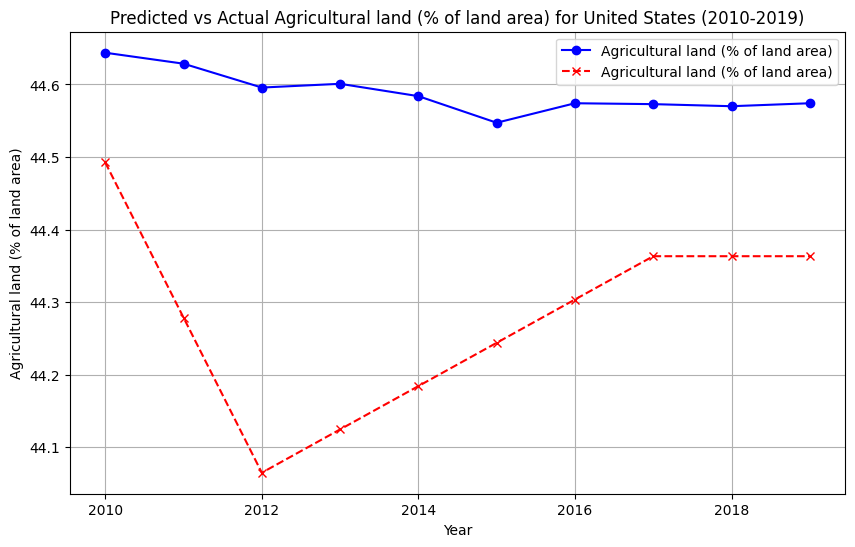

In [20]:
# Function to plot predictions vs actual values for a test country
# Useful for visual assessment of accuracy of the model

# Redefining test_df based on the years 2010-2019 from selected_df
test_df = selected_df_2[(selected_df_2['Year'] >= 2010) & (selected_df_2['Year'] <= 2019)].dropna(subset=['Agricultural land (% of land area)'])

# Rerun the plotting function for Kenya as an example
plot_country_predictions_vs_actual("United States", "Agricultural land (% of land area)")

In [21]:
# Define year variables for training and prediction
TRAIN_START_YEAR = 2000
TRAIN_END_YEAR = 2019
PREDICTION_START_YEAR = 2019
PREDICTION_END_YEAR = 2030

# Setting up logging configuration
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger()

# Splitting data into training (2000-2019) set and setting up prediction years
train_df = selected_df_2[(selected_df_2['Year'] >= TRAIN_START_YEAR) & (selected_df_2['Year'] <= TRAIN_END_YEAR)].dropna(subset=['Agricultural land (% of land area)'])
prediction_years = range(PREDICTION_START_YEAR, PREDICTION_END_YEAR + 1)

# Preparing training data for the model
X_train = train_df[['Year', 'AL Moving_Avg_2Y', 'AL Moving_Avg_3Y', 'AL Moving_Avg_5Y', 'AL Moving_Avg_10Y']].values
y_train = train_df['Agricultural land (% of land area)'].values

# Initializing and training the Random Forest model on all training data
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)
logger.info(f"Model trained on all countries' data ({TRAIN_START_YEAR}-{TRAIN_END_YEAR}). Starting recursive forecasting.")

# Dictionary to store predictions for each country
country_recursive_predictions_rf = {}

# Recursive forecasting for each country separately with detailed logging
for country in train_df['Country Name'].unique():
    logger.info(f"Processing country: {country}")

    # Get the last available data point for the country to start recursive prediction
    country_data = train_df[train_df['Country Name'] == country].iloc[-1].copy()
    predictions_per_country = {country_data['Year']: country_data['Agricultural land (% of land area)']}

    # Recursive prediction loop from PREDICTION_START_YEAR to PREDICTION_END_YEAR
    for year in prediction_years:
        country_data['Year'] = year
        
        # Logging the input data used for this prediction
        logger.info(f"Prediction inputs for {country} in {year}: Year={year}, "
                    f"AL Moving_Avg_2Y={country_data['AL Moving_Avg_2Y']}, "
                    f"AL Moving_Avg_3Y={country_data['AL Moving_Avg_3Y']}, "
                    f"AL Moving_Avg_5Y={country_data['AL Moving_Avg_5Y']}, "
                    f"AL Moving_Avg_10Y={country_data['AL Moving_Avg_10Y']}")
        
        # Preparing the features for the current prediction
        X_test = country_data[['Year', 'AL Moving_Avg_2Y', 'AL Moving_Avg_3Y', 'AL Moving_Avg_5Y', 'AL Moving_Avg_10Y']].values.reshape(1, -1)
        
        # Predicting agricultural land use for the current year
        predicted_value = model_rf.predict(X_test)[0]
        logger.info(f"Predicted value for {country} in {year}: {predicted_value}")
        
        # Update the prediction in the dictionary
        predictions_per_country[year] = predicted_value
        
        # Update the features for the next prediction year based on the new prediction
        country_data['Agricultural land (% of land area)'] = predicted_value
        country_data['AL Moving_Avg_2Y'] = (predictions_per_country.get(year - 1, predicted_value) + predicted_value) / 2
        country_data['AL Moving_Avg_3Y'] = (predictions_per_country.get(year - 2, predicted_value) +
                                         predictions_per_country.get(year - 1, predicted_value) + predicted_value) / 3
        country_data['AL Moving_Avg_5Y'] = (sum(predictions_per_country.get(y, predicted_value) for y in range(year - 4, year + 1)) / 5)
        country_data['AL Moving_Avg_10Y'] = (sum(predictions_per_country.get(y, predicted_value) for y in range(year - 9, year + 1)) / 10)

    # Store the predictions for the country
    country_recursive_predictions_rf[country] = predictions_per_country

2024-11-19 16:25:10,350 - INFO - Model trained on all countries' data (2000-2019). Starting recursive forecasting.
2024-11-19 16:25:10,351 - INFO - Processing country: Afghanistan
2024-11-19 16:25:10,352 - INFO - Prediction inputs for Afghanistan in 2019: Year=2019, AL Moving_Avg_2Y=58.2769881790166, AL Moving_Avg_3Y=58.22588146308306, AL Moving_Avg_5Y=58.184996090336234, AL Moving_Avg_10Y=58.156785183140926
2024-11-19 16:25:10,354 - INFO - Predicted value for Afghanistan in 2019: 58.312729703808735
2024-11-19 16:25:10,355 - INFO - Prediction inputs for Afghanistan in 2020: Year=2020, AL Moving_Avg_2Y=58.312729703808735, AL Moving_Avg_3Y=58.312729703808735, AL Moving_Avg_5Y=58.312729703808735, AL Moving_Avg_10Y=58.31272970380873
2024-11-19 16:25:10,357 - INFO - Predicted value for Afghanistan in 2020: 58.38285559270273
2024-11-19 16:25:10,357 - INFO - Prediction inputs for Afghanistan in 2021: Year=2021, AL Moving_Avg_2Y=58.347792648255734, AL Moving_Avg_3Y=58.35948029640473, AL Moving

In [22]:
# Converting the dictionary of predictions for each country (country_recursive_predictions_rf) into a DataFrame
# Initialize an empty list to store rows for the DataFrame
rows = []

# Loop through each country and its predictions to build the DataFrame rows
for country, predictions in country_recursive_predictions_rf.items():
    for year, ag_land in predictions.items():
        # Append each prediction as a new row with the country, year, and predicted value
        rows.append({'Country Name': country, 'Year': year, 'Agricultural land (% of land area)': ag_land})

# Convert the list of rows into a DataFrame
predictions_df_2= pd.DataFrame(rows)

In [23]:
# Displaying feature importances from the Random Forest model directly

# Calculating feature importances
feature_importances = model_rf.feature_importances_
feature_names = ['Year', 'Moving_Avg_2Y', 'Moving_Avg_3Y', 'Moving_Avg_5Y', 'Moving_Avg_10Y']

# Creating a DataFrame to organize and sort feature importances
import pandas as pd
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

## Indicator 3 - Train and Test Machine Learning 

In [24]:
# Selecting specified columns
selected_df_3 = merged_df[['Country Name', 'Country Code', 'Year', 'Population density (people per sq. km of land area)']].copy()

# Sorting by 'Country Name' and 'Year' to prepare for rolling calculations
selected_df_3 = selected_df_3.sort_values(by=['Country Name', 'Year'])

selected_df_3['Year'] = selected_df_3['Year'].astype(int)

# Creating Moving Average and STD columns for the specified time frames (2, 3, 5, and 10 years)
# time_frames = [2, 3, 5, 10]
time_frames = [2, 3, 5, 10]
for window in time_frames:
    selected_df_3[f'PD Moving_Avg_{window}Y'] = selected_df_3.groupby('Country Name')['Population density (people per sq. km of land area)'].transform(lambda x: x.rolling(window, min_periods=1).mean())
    # selected_df[f'STD_{window}Y'] = selected_df.groupby('Country Name')['Life expectancy at birth, total (years)'].transform(lambda x: x.rolling(window, min_periods=1).std())

# Displaying the first few rows of the updated DataFrame
selected_df_3.loc[selected_df_3['Country Name'] == 'Austria']

,Country Name,Country Code,Year,Population density (people per sq. km of land area),PD Moving_Avg_2Y,PD Moving_Avg_3Y,PD Moving_Avg_5Y,PD Moving_Avg_10Y
567,Austria,AUT,1960,NaN,NaN,NaN,NaN,NaN
568,Austria,AUT,1961,85.873715,85.873715,85.873715,85.873715,85.873715
569,Austria,AUT,1962,86.401648,86.137682,86.137682,86.137682,86.137682
570,Austria,AUT,1963,86.958446,86.680047,86.411270,86.411270,86.411270
571,Austria,AUT,1964,87.540002,87.249224,86.966699,86.693453,86.693453
...,...,...,...,...,...,...,...,...
625,Austria,AUT,2018,107.131859,106.871589,106.538839,105.583640,103.698490
626,Austria,AUT,2019,107.609307,107.370583,107.117495,106.392084,104.348753
627,Austria,AUT,2020,108.057004,107.833156,107.599390,107.056566,105.019451
628,Austria,AUT,2021,108.528805,108.292905,108.065039,107.587659,105.703108


In [ ]:
# Define year variables for training and prediction
TRAIN_START_YEAR = 1990
TRAIN_END_YEAR = 2009
PREDICTION_START_YEAR = 2010
PREDICTION_END_YEAR = 2019

# Setting up logging configuration
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger()

# Splitting data into training (2000-2019) set and setting up prediction years
train_df_3 = selected_df_3[(selected_df_3['Year'] >= TRAIN_START_YEAR) & (selected_df_3['Year'] <= TRAIN_END_YEAR)].dropna(subset=['Population density (people per sq. km of land area)'])
prediction_years = range(PREDICTION_START_YEAR, PREDICTION_END_YEAR + 1)

# Preparing training data for the model
X_train = train_df_3[['Year', 'PD Moving_Avg_2Y', 'PD Moving_Avg_3Y', 'PD Moving_Avg_5Y', 'PD Moving_Avg_10Y']].values
y_train = train_df_3['Population density (people per sq. km of land area)'].values

# Initializing and training the Random Forest model on all training data
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)
logger.info(f"Model trained on all countries' data ({TRAIN_START_YEAR}-{TRAIN_END_YEAR}). Starting recursive forecasting.")

# Dictionary to store predictions for each country
country_recursive_predictions_rf = {}

# Recursive forecasting for each country separately with detailed logging
for country in train_df_3['Country Name'].unique():
    logger.info(f"Processing country: {country}")

    # Get the last available data point for the country to start recursive prediction
    country_data = train_df_3[train_df_3['Country Name'] == country].iloc[-1].copy()
    predictions_per_country = {country_data['Year']: country_data['Population density (people per sq. km of land area)']}

    # Recursive prediction loop from PREDICTION_START_YEAR to PREDICTION_END_YEAR
    for year in prediction_years:
        country_data['Year'] = year
        
        # Logging the input data used for this prediction
        logger.info(f"Prediction inputs for {country} in {year}: Year={year}, "
                    f"PD Moving_Avg_2Y={country_data['PD Moving_Avg_2Y']}, "
                    f"PD Moving_Avg_3Y={country_data['PD Moving_Avg_3Y']}, "
                    f"PD Moving_Avg_5Y={country_data['PD Moving_Avg_5Y']}, "
                    f"PD Moving_Avg_10Y={country_data['PD Moving_Avg_10Y']}")
        
        # Preparing the features for the current prediction
        X_test = country_data[['Year', 'PD Moving_Avg_2Y', 'PD Moving_Avg_3Y', 'PD Moving_Avg_5Y', 'PD Moving_Avg_10Y']].values.reshape(1, -1)
        
        # Predicting life expectancy for the current year
        predicted_value = model_rf.predict(X_test)[0]
        logger.info(f"Predicted value for {country} in {year}: {predicted_value}")
        
        # Update the prediction in the dictionary
        predictions_per_country[year] = predicted_value
        
        # Update the features for the next prediction year based on the new prediction
        country_data['Population density (people per sq. km of land area)'] = predicted_value
        country_data['PD Moving_Avg_2Y'] = (predictions_per_country.get(year - 1, predicted_value) + predicted_value) / 2
        country_data['PD Moving_Avg_3Y'] = (predictions_per_country.get(year - 2, predicted_value) +
                                         predictions_per_country.get(year - 1, predicted_value) + predicted_value) / 3
        country_data['PD Moving_Avg_5Y'] = (sum(predictions_per_country.get(y, predicted_value) for y in range(year - 4, year + 1)) / 5)
        country_data['PD Moving_Avg_10Y'] = (sum(predictions_per_country.get(y, predicted_value) for y in range(year - 9, year + 1)) / 10)

    # Store the predictions for the country
    country_recursive_predictions_rf[country] = predictions_per_country

2024-11-19 16:25:17,360 - INFO - Model trained on all countries' data (1990-2009). Starting recursive forecasting.
2024-11-19 16:25:17,361 - INFO - Processing country: Afghanistan
2024-11-19 16:25:17,362 - INFO - Prediction inputs for Afghanistan in 2010: Year=2010, PD Moving_Avg_2Y=41.2527068672094, PD Moving_Avg_3Y=40.740131037619626, PD Moving_Avg_5Y=39.731365315916165, PD Moving_Avg_10Y=36.183630467779764
2024-11-19 16:25:17,364 - INFO - Predicted value for Afghanistan in 2010: 41.85541467310776
2024-11-19 16:25:17,364 - INFO - Prediction inputs for Afghanistan in 2011: Year=2011, PD Moving_Avg_2Y=41.92130392058098, PD Moving_Avg_3Y=41.899340838089906, PD Moving_Avg_5Y=41.88177037209705, PD Moving_Avg_10Y=41.868592522602405
2024-11-19 16:25:17,367 - INFO - Predicted value for Afghanistan in 2011: 41.86779262908249
2024-11-19 16:25:17,367 - INFO - Prediction inputs for Afghanistan in 2012: Year=2012, PD Moving_Avg_2Y=41.86160365109512, PD Moving_Avg_3Y=41.90346682341482, PD Moving_A

In [ ]:
# Initialize lists to collect all actual and predicted values across countries
all_actual_values = []
all_predicted_values = []

for country, predictions in country_recursive_predictions_rf.items():
    predicted_years = list(predictions.keys())
    predicted_values = list(predictions.values())

    # Extract actual values from selected_df for the specified prediction years
    actual_data = selected_df_3[(selected_df_3['Country Name'] == country) & (selected_df_3['Year'].isin(predicted_years))]
    actual_values = actual_data['Population density (people per sq. km of land area)'].values

    # Ensure no NaN or inf values in actual and predicted values
    if len(actual_values) == len(predicted_values):
        actual_values_clean = np.array(actual_values)
        predicted_values_clean = np.array(predicted_values)
        
        # Filter out any NaN or inf values
        valid_indices = ~np.isnan(actual_values_clean) & ~np.isinf(actual_values_clean) & \
                        ~np.isnan(predicted_values_clean) & ~np.isinf(predicted_values_clean)
        actual_values_clean = actual_values_clean[valid_indices]
        predicted_values_clean = predicted_values_clean[valid_indices]

        # Append clean values to the overall lists
        all_actual_values.extend(actual_values_clean)
        all_predicted_values.extend(predicted_values_clean)

# Calculate overall metrics across all countries
if len(all_actual_values) > 0:
    overall_mae = mean_absolute_error(all_actual_values, all_predicted_values)
    overall_mse = mean_squared_error(all_actual_values, all_predicted_values)
    overall_rmse = np.sqrt(overall_mse)
    overall_r2 = r2_score(all_actual_values, all_predicted_values)

else:
    logger.warning("No valid values available for metric calculation.")

# Displaying the overall metrics
print(f"Overall Mean Absolute Error (MAE): {overall_mae:.2f}")
print(f"Overall Mean Squared Error (MSE): {overall_mse:.2f}")
print(f"Overall Root Mean Squared Error (RMSE): {overall_rmse:.2f}")
print(f"Overall R-squared (R²): {overall_r2:.2f}")

In [ ]:
# Initialize lists to collect all actual, predicted values, and years across countries
all_actual_values = []
all_predicted_values = []
all_years = []

for country, predictions in country_recursive_predictions_rf.items():
    # Get predictions and corresponding years
    predicted_years = [year for year in predictions.keys() if year >= 2010]
    predicted_values = [predictions[year] for year in predicted_years]

    # Extract actual values from selected_df for the specified prediction years
    actual_data = selected_df_3[(selected_df_3['Country Name'] == country) & (selected_df_3['Year'].isin(predicted_years))]
    actual_values = actual_data['Population density (people per sq. km of land area)'].values
    years = actual_data['Year'].values

    # Ensure no NaN or inf values in actual and predicted values
    if len(actual_values) == len(predicted_values):
        actual_values_clean = np.array(actual_values)
        predicted_values_clean = np.array(predicted_values)
        
        # Filter out any NaN or inf values
        valid_indices = ~np.isnan(actual_values_clean) & ~np.isinf(actual_values_clean) & \
                        ~np.isnan(predicted_values_clean) & ~np.isinf(predicted_values_clean)
        
        actual_values_clean = actual_values_clean[valid_indices]
        predicted_values_clean = predicted_values_clean[valid_indices]
        years_clean = years[valid_indices]

        # Append clean values from 2010 onward to the overall lists
        all_actual_values.extend(actual_values_clean)
        all_predicted_values.extend(predicted_values_clean)
        all_years.extend(years_clean)

# Create a DataFrame for easier plotting with hue
plot_data = pd.DataFrame({
    'Actual': all_actual_values,
    'Predicted': all_predicted_values,
    'Residuals': np.array(all_actual_values) - np.array(all_predicted_values),
    'Year': all_years
})

In [ ]:
# Redefining test_df based on the years 2010-2019 from selected_df
test_df = selected_df_3[(selected_df_3['Year'] >= 2010) & (selected_df_3['Year'] <= 2019)].dropna(subset=['Population density (people per sq. km of land area)'])

# Rerun the plotting function for Kenya as an example
plot_country_predictions_vs_actual("United States", "Population density (people per sq. km of land area)")

## Indicator 3 - Forecasting

In [ ]:
# Define year variables for training and prediction
TRAIN_START_YEAR = 2000
TRAIN_END_YEAR = 2019
PREDICTION_START_YEAR = 2019
PREDICTION_END_YEAR = 2030

# Setting up logging configuration
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger()

# Splitting data into training (2000-2019) set and setting up prediction years
train_df = selected_df_3[(selected_df_3['Year'] >= TRAIN_START_YEAR) & (selected_df_3['Year'] <= TRAIN_END_YEAR)].dropna(subset=['Population density (people per sq. km of land area)'])
prediction_years = range(PREDICTION_START_YEAR, PREDICTION_END_YEAR + 1)

# Preparing training data for the model
X_train = train_df[['Year', 'PD Moving_Avg_2Y', 'PD Moving_Avg_3Y', 'PD Moving_Avg_5Y', 'PD Moving_Avg_10Y']].values
y_train = train_df['Population density (people per sq. km of land area)'].values

# Initializing and training the Random Forest model on all training data
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)
logger.info(f"Model trained on all countries' data ({TRAIN_START_YEAR}-{TRAIN_END_YEAR}). Starting recursive forecasting.")

# Dictionary to store predictions for each country
country_recursive_predictions_rf = {}

# Recursive forecasting for each country separately with detailed logging
for country in train_df['Country Name'].unique():
    logger.info(f"Processing country: {country}")

    # Get the last available data point for the country to start recursive prediction
    country_data = train_df[train_df['Country Name'] == country].iloc[-1].copy()
    predictions_per_country = {country_data['Year']: country_data['Population density (people per sq. km of land area)']}

    # Recursive prediction loop from PREDICTION_START_YEAR to PREDICTION_END_YEAR
    for year in prediction_years:
        country_data['Year'] = year
        
        # Logging the input data used for this prediction
        logger.info(f"Prediction inputs for {country} in {year}: Year={year}, "
                    f"PD Moving_Avg_2Y={country_data['PD Moving_Avg_2Y']}, "
                    f"PD Moving_Avg_3Y={country_data['PD Moving_Avg_3Y']}, "
                    f"PD Moving_Avg_5Y={country_data['PD Moving_Avg_5Y']}, "
                    f"PD Moving_Avg_10Y={country_data['PD Moving_Avg_10Y']}")
        
        # Preparing the features for the current prediction
        X_test = country_data[['Year', 'PD Moving_Avg_2Y', 'PD Moving_Avg_3Y', 'PD Moving_Avg_5Y', 'PD Moving_Avg_10Y']].values.reshape(1, -1)
        
        # Predicting life expectancy for the current year
        predicted_value = model_rf.predict(X_test)[0]
        logger.info(f"Predicted value for {country} in {year}: {predicted_value}")
        
        # Update the prediction in the dictionary
        predictions_per_country[year] = predicted_value
        
        # Update the features for the next prediction year based on the new prediction
        country_data['Population density (people per sq. km of land area)'] = predicted_value
        country_data['PD Moving_Avg_2Y'] = (predictions_per_country.get(year - 1, predicted_value) + predicted_value) / 2
        country_data['PD Moving_Avg_3Y'] = (predictions_per_country.get(year - 2, predicted_value) +
                                         predictions_per_country.get(year - 1, predicted_value) + predicted_value) / 3
        country_data['PD Moving_Avg_5Y'] = (sum(predictions_per_country.get(y, predicted_value) for y in range(year - 4, year + 1)) / 5)
        country_data['PD Moving_Avg_10Y'] = (sum(predictions_per_country.get(y, predicted_value) for y in range(year - 9, year + 1)) / 10)

    # Store the predictions for the country
    country_recursive_predictions_rf[country] = predictions_per_country

In [ ]:
# Displaying feature importances from the Random Forest model directly

# Calculating feature importances
feature_importances = model_rf.feature_importances_
feature_names = ['Year', 'SPEI Moving_Avg_2Y', 'SPEI Moving_Avg_3Y', 'SPEI Moving_Avg_5Y', 'SPEI Moving_Avg_10Y']

# Creating a DataFrame to organize and sort feature importances
import pandas as pd
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

In [ ]:
# Converting the dictionary of predictions for each country (country_recursive_predictions_rf) into a DataFrame

# Initialize an empty list to store rows for the DataFrame
rows = []

# Loop through each country and its predictions to build the DataFrame rows
for country, predictions in country_recursive_predictions_rf.items():
    for year, precip in predictions.items():
        # Append each prediction as a new row with the country, year, and predicted value
        rows.append({'Country Name': country, 'Year': year, 'Population density (people per sq. km of land area)': precip})

# Convert the list of rows into a DataFrame
predictions_df_3 = pd.DataFrame(rows)

In [ ]:
#Remove country code columns
selected_df_clean = selected_df.drop(['Country Code'],axis=1)
selected_df_2_clean = selected_df_2.drop(['Country Code'],axis=1)
selected_df_3_clean = selected_df_3.drop(['Country Code'],axis=1)

In [ ]:
#Combine historical data from cleaned dataframes
combined_hist_df_1_2=pd.merge(selected_df_clean, selected_df_2_clean, on=['Country Name', 'Year','Agricultural land (% of land area)'], how='outer')
combined_hist_df_1_2_3 = pd.merge(combined_hist_df_1_2, selected_df_3_clean, on=['Country Name', 'Year','Population density (people per sq. km of land area)'], how='outer')

#Drop moving averages columns
columns_to_drop = combined_hist_df_1_2_3.columns[combined_hist_df_1_2_3.columns.str.contains('Moving_Avg')]
combined_hist_df_1_2_3_clean = combined_hist_df_1_2_3.drop(columns=columns_to_drop)

#Remove data from 2019 or greater, define historical data as all data before 2020 as our predictions begin in 2020
combined_hist_filtered = combined_hist_df_1_2_3_clean[combined_hist_df_1_2_3_clean['Year'] <= 2019]

#Combine predicted dataframes
combined_pred_1_2=pd.merge(predictions_df_1, predictions_df_2, on=['Country Name', 'Year'], how='outer')
combined_pred=pd.merge(combined_pred_1_2, predictions_df_3, on=['Country Name', 'Year'], how='outer')

#Ensure to only include predicted data from 2019 or greater
combined_pred_filtered = combined_pred[combined_pred['Year'] >= 2020]
combined_pred_filtered.columns = combined_hist_filtered.columns
combined_df = pd.merge(combined_hist_filtered, combined_pred_filtered,on = ['Country Name','Year','Life expectancy at birth, total (years)','Agricultural land (% of land area)','Population density (people per sq. km of land area)'], how='outer')


In [ ]:
#Export results to a df to be read for finalized plotting

combined_df.to_excel('Historical and Predicted Indicator Data.xlsx', sheet_name='Results', index=False)